# Исследование тарифных планов

<b>Выборка исследования:</b> данные 500 пользователей «Мегалайна» (оператор сотовой связи): кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

<b>Цель:</b> клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Необходимо понять, какой тариф приносит больше денег.

<b>Тариф «Смарт»</b>
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
•	минута разговора: 3 рубля
•	сообщение: 3 рубля
•	1 Гб интернет-трафика: 200 рублей


<b>Тариф «Ультра»</b>
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
•	минута разговора: 1 рубль
•	сообщение: 1 рубль
•	1 Гб интернет-трафика: 150 рублей

Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## 1. Обзор и подготовка данных

In [1]:
#Библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st

In [2]:
#Загрузка данных

data_calls = pd.read_csv('/datasets/calls.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_users = pd.read_csv('/datasets/users.csv')

In [3]:
data_calls.info()
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_calls['month'] = data_calls['call_date'].dt.month
def good_calls_ceil(row):
    duration = row['duration']
    duration = math.ceil(duration)
    return duration

data_calls['duration'] = data_calls.apply(good_calls_ceil, axis=1)
good_calls = data_calls.query('duration != 0.00')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
data_internet.info()
data_internet.drop(['Unnamed: 0'], axis='columns', inplace=True)
good_internet = data_internet.query('mb_used != 0.00')
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_internet['month'] = data_internet['session_date'].dt.month
data_internet['gb_used'] = round((data_internet['mb_used']/1024),3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [5]:
data_messages.info()
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_messages['month'] = data_messages['message_date'].dt.month

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [6]:
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [7]:
data_users.info()
data_users[data_users['churn_date'].isnull()==False].head()
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


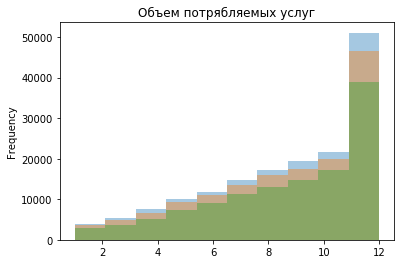

In [8]:
good_calls['month'].plot(kind='hist',y='duration', alpha=0.4)
data_internet['month'].plot(kind='hist',y='mb_used', alpha=0.4)
data_messages['month'].plot(kind='hist', alpha=0.4)
plt.title('Объем потрябляемых услуг')
plt.show()

На графике можно наблидать рост числа звонков, отправки смс и использования интернет-трафика. Возможно, это связано с тем что компания активно подключает клиентов на новые тарифы.<br>
В датафрейме 'звонки' был выделен новый фрейм без звонков дительностью 0.00.<br>
В фрейме 'интернет' был удален столбец <i>'Unnamed: 0'</i> дублирующий user_id и выделен фрейм без строк с нулевым интернет трафиком.

In [9]:
data_calls_group = (data_calls.groupby(['user_id', 'month'])
                    .agg({'id': 'count', 'duration': 'sum'})
                    .rename(columns={'id':'calls_count', 'duration':'calls_duration_sum'})
                    .reset_index()
                   )

In [10]:
data_internet_group = (data_internet.groupby(['user_id', 'month'])
                    .agg({'gb_used': 'sum'})
                    .rename(columns={'gb_used':'gb_used_sum'})
                    .reset_index()
                   )
def data_internet_ceil(row):
    gb_used_sum = row['gb_used_sum']
    gb_used_sum = math.ceil(gb_used_sum)
    return gb_used_sum

data_internet_group['gb_used_sum'] = data_internet_group.apply(data_internet_ceil, axis=1)

In [11]:
data_messages_group = (data_messages.groupby(['user_id', 'month'])
                    .agg({'message_date': 'count'})
                    .rename(columns={'message_date':'messages_count'})
                    .reset_index()
                   )

In [12]:
data_users_revenue = pd.DataFrame()

data_users_revenue = (
    data_internet_group
    .merge(data_calls_group, on=['user_id', 'month'], how='left')
    .merge(data_users[['user_id','tariff']], on='user_id', how='left')
    .merge(data_messages_group, on=['user_id', 'month'], how='left')
    
)

In [13]:
def revenue_count(row):
    
    tar_index = 0
    calls = row['calls_duration_sum']
    messages = row['messages_count']
    gb_used = row['gb_used_sum']
    tariff = row['tariff']
    if str(tariff) == 'ultra':
            tar_index = 1
            
    messages_included = data_tariffs['messages_included'][tar_index]
    gb_per_month_included = data_tariffs['mb_per_month_included'][tar_index]/1024
    minutes_included = data_tariffs['minutes_included'][tar_index]
    rub_monthly_fee = data_tariffs['rub_monthly_fee'][tar_index]
    
    rub_per_gb = data_tariffs['rub_per_gb'][tar_index]
    rub_per_message = data_tariffs['rub_per_message'][tar_index]
    rub_per_minute = data_tariffs['rub_per_minute'][tar_index]
    
    minutes_add = 0
    messages_add = 0
    internet_add = 0
    if minutes_included < calls:
        minutes_add = (calls - minutes_included)*rub_per_minute
    if messages_included < messages:
        messages_add = (messages - messages_included)*rub_per_message
    if gb_per_month_included < gb_used:    
        internet_add = (gb_used - gb_per_month_included)*rub_per_gb
    revenue = (
        rub_monthly_fee + minutes_add + messages_add + internet_add
    )
    return revenue
    
data_users_revenue['revenue'] = data_users_revenue.apply(revenue_count, axis=1)

## 2. Анализ данных

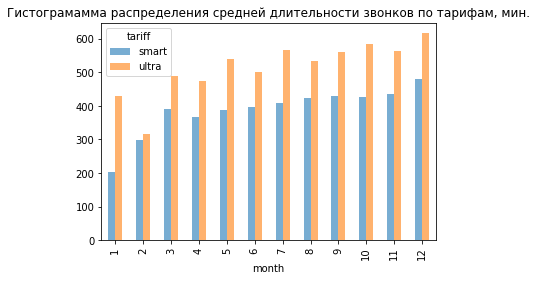

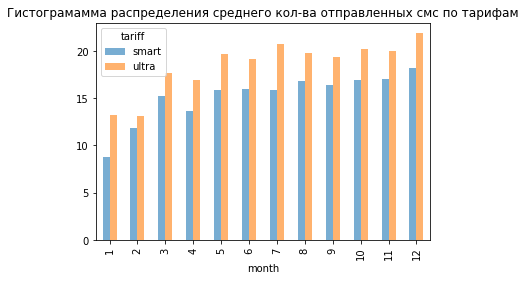

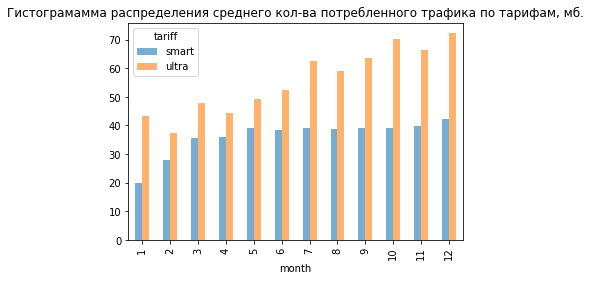

In [14]:
(data_users_revenue
    .pivot_table(index='tariff', columns='month', values='calls_duration_sum', aggfunc='mean')
    .T.plot(kind='bar', alpha=0.6)
)
plt.title('Гистограмамма распределения средней длительности звонков по тарифам, мин.')
(data_users_revenue
    .pivot_table(index='tariff', columns='month', values='gb_used_sum', aggfunc='mean')
    .T.plot(kind='bar', alpha=0.6)
)
plt.title('Гистограмамма распределения среднего кол-ва отправленных смс по тарифам')
(data_users_revenue
    .pivot_table(index='tariff', columns='month', values='messages_count', aggfunc='mean')
    .T.plot(kind='bar', alpha=0.6)
)
plt.title('Гистограмамма распределения среднего кол-ва потребленного трафика по тарифам, мб.')
plt.show()

> **_<span style="color:black">Здесь python ругается на такой метод замены значений. Безопаснее использовать замену через функцию `loc`.</span>_**

Из графиков контрольных сумм видно, как растет кол-во используемых услуг с ростом кол-ва пользователей. Средние же значения имеют умеренный рост показателей. Обнаружены аномально низкие показатели по всем услугам в Феврале.

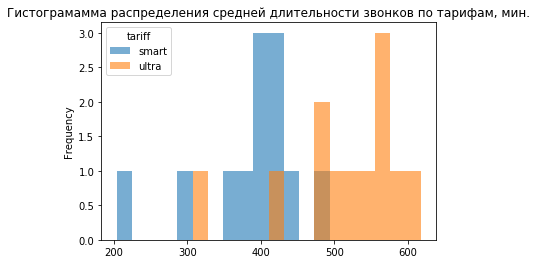

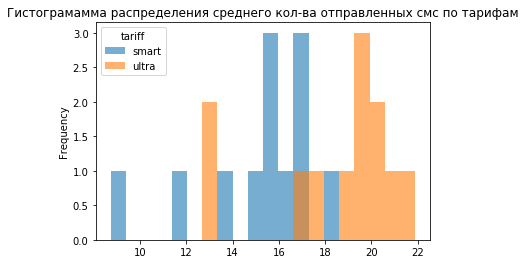

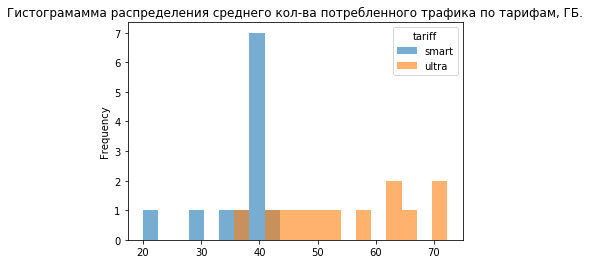

In [15]:
(data_users_revenue
    .pivot_table(index='tariff', columns='month', values='calls_duration_sum', aggfunc='mean')
    .T.plot(kind='hist', alpha=0.6, bins=20)
)
plt.title('Гистограмамма распределения средней длительности звонков по тарифам, мин.')
(data_users_revenue
    .pivot_table(index='tariff', columns='month', values='gb_used_sum', aggfunc='mean')
    .T.plot(kind='hist', alpha=0.6, bins=20)
)
plt.title('Гистограмамма распределения среднего кол-ва отправленных смс по тарифам')
(data_users_revenue
    .pivot_table(index='tariff', columns='month', values='messages_count', aggfunc='mean')
    .T.plot(kind='hist', alpha=0.6, bins=20)
)
plt.title('Гистограмамма распределения среднего кол-ва потребленного трафика по тарифам, ГБ.')
plt.show()

Пользователи тарифа smart пользуются меньшим обьемом услуг, чем клиенты с тарифом ultra, но чаще выходят за рамки тарифа. Так же наблюдается частое превышение лимитов трафика у пользователей тарифа смарт.

### Анализ выручки

In [16]:
total_revenue = (data_users_revenue
    .pivot_table(index='user_id', values=['revenue','tariff'], aggfunc={'revenue': 'mean', 'tariff': 'first'})
    .reset_index()
    .rename(columns={'revenue':'mean_revenue'})
                )

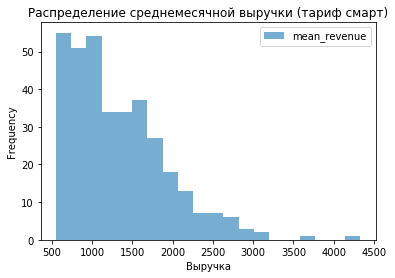

In [17]:
(total_revenue
    .query('tariff=="smart"')
    .plot(kind='hist', y='mean_revenue', alpha=0.6, bins=20)
)
plt.title('Распределение среднемесячной выручки (тариф смарт)')
plt.xlabel('Выручка')
plt.show()

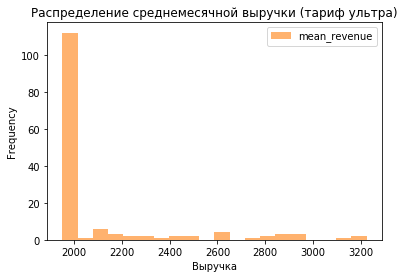

In [18]:
(total_revenue
    .query('tariff=="ultra"')
    .plot(kind='hist', y='mean_revenue',facecolor='tab:orange', alpha=0.6, bins=20)
)
plt.title('Распределение среднемесячной выручки (тариф ультра)')
plt.xlabel('Выручка')
plt.show()

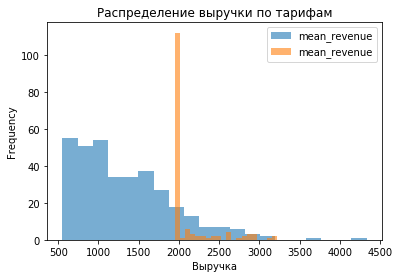

In [19]:
ax = (total_revenue
    .query('tariff=="smart"')
    .plot(kind='hist', y='mean_revenue', alpha=0.6, bins=20)
)
(total_revenue
    .query('tariff=="ultra"')
    .plot(kind='hist', y='mean_revenue', facecolor='tab:orange', ax=ax, alpha=0.6, bins=20)
)
plt.title('Распределение выручки по тарифам')
plt.xlabel('Выручка')
plt.show()

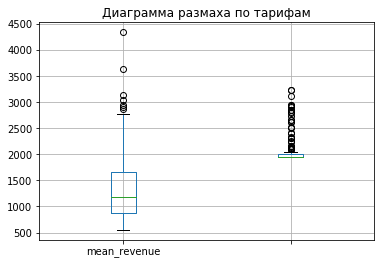

In [20]:
total_revenue.query('tariff=="smart"').boxplot('mean_revenue', positions=[1], labels=['smart'])
total_revenue.query('tariff=="ultra"').boxplot('mean_revenue', positions=[2], labels=['ultra'])
plt.title('Диаграмма размаха по тарифам')
plt.show()

In [21]:
#Расчет дисперсии и стандартного отклонения среднемесячной выручки
def variance_count(data):
    variance_estimate = np.var(data, ddof=1)
    print(variance_estimate)
print('Дисперсия')    
variance_count(total_revenue['mean_revenue'])
print('-----------')
print('Стандартное отклонение')
def standart_dev_count(data):
    standart_dev = np.std(data, ddof=1)
    print(standart_dev)
standart_dev_count(total_revenue['mean_revenue'])

Дисперсия
406293.10361591756
-----------
Стандартное отклонение
637.4112515604958


In [22]:
total_revenue.pivot_table(index='tariff',values='mean_revenue', aggfunc='mean')

,mean_revenue
tariff,
smart,1324.719019
ultra,2087.392990


In [23]:
(total_revenue[['tariff','mean_revenue']]
               .sort_values(by='mean_revenue', ascending=False)
               .head())

,tariff,mean_revenue
483,smart,4333.333333
260,smart,3628.666667
302,ultra,3225.000000
124,ultra,3225.000000
42,smart,3129.500000


Из графиков видно, что большинство пользователей тарифа ультра укалдывается в базовый объем предоставляемых услуг. Чего нельзя сказать о пользователях тарифа смарт. Расходы пользователнй тарифа смарт в среднем в несколько раз превышают ежемясячную плату по тарифу. Максимальная среднемесячная выручка наблюдается именно у пользователей тарифа смарт.<br>
График распределения среднемесячной выручки пользователей тарифа смарт более похож на график нормального распределения, чем график распределения для пользователей тарифа ультра.

## 3. Проверка гипотезы

В рамках исследования необходимо проверить две гипотезы:<br>
•	средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;<br>
•	средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;<br><br>

Для проверки данных гипотез сформулируем двусторонние гипотезы. Двустороннюю гипотезу мы выбираем, т.к. мы не знаем в какую сторону (большую или меньшую) может измениться среднемесячная выручка.<br>
Нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства. Исходя из нулевой гипотезы формулируется альтернативная гипотеза.

### Гипотеза 1

<b>Нулевая гипотеза:</b> средние выручки пользователей тарифов «Ультра» и «Смарт» равны.<br>
<b>Альтернативаня гипотеза:</b> средние выручки пользователей тарифов «Ультра» и «Смарт» не равны.<br>

In [25]:
mean_smart_revenue = total_revenue.query('tariff=="smart"')['mean_revenue']
mean_ultra_revenue = total_revenue.query('tariff=="ultra"')['mean_revenue']
results = st.ttest_ind(mean_smart_revenue,mean_ultra_revenue)
alpha = 0.05

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  4.571202126579977e-40
Отвергаем нулевую гипотезу


<b>Вывод:</b> Значение pvalue слишком мало, чтобы принять гипотезу о равенстве выручек.

### Гипотеза 2

<b>Нулевая гипотеза:</b> выручка пользователей из Москвы не отличается от выручки пользователей из других регионов<br>
<b>Альтернативаня гипотеза:</b> выручка пользователей из Москвы отличается от выручки пользователей из других регионов<br>

In [26]:
total_revenue['city'] = data_users['city']
mean_msk_revenue = total_revenue.query('city=="Москва"')['mean_revenue']
mean_zamkad_revenue = total_revenue.query('city!="Москва"')['mean_revenue']
results = st.ttest_ind(mean_msk_revenue,mean_zamkad_revenue)
alpha = 0.05

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.7099092178210239
Не получилось отвергнуть нулевую гипотезу


<b>Вывод:</b> Значение pvalue указывает на то, выручка пользвателей отличается, но вероятность того, что это произошло случайно, довольно высока (почти 71%).

## 4. Общий вывод

В рамках исследования были проверенны данные 500 пользователей услуг провайдера "Мегалайн".<br>
Обзор данных показал, что пользователи тарифа смарт чаще выходя за рамки услуг, предоставленных на тарифном плане. Так же, суммарные показатели использования услуг у тарифного плана смарт выше чем у тарифного плана ультра.<br>
Наибольшая среднемесячная выручка наблюдается у пользователей тарифа смарт (4333 руб.).<br>
Среднемесячная выручка пользователей тарифа смарт в среднем на в 3 раза выше абонентской платы по тарифу , в то время как среднемясячная выручка пользователей тарифа ультра не значительно отличается от ежемесячной платы (около 10%).<br>
Гипотеза о равенстве выручек не была подтверждена.<br>
Гипотезу о различии выручек Москвы и других регионов не удалось опровергнуть, но высока вероятность что эти значения получены случайно.<br><br>

<b>Вывод:</b> для компании Мегалайн тариф Смарт является более прибыльным тарифом.